# Exemple d'une solution simplifiée du devoir#1#

Prenez note que cette solution utilise la dernière version de scikit-learn: 1.4.0


In [1]:
#Chargement des modules commun
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import *
from sklearn.compose import *

In [3]:
#lecture du dataset. A la lecture, les valeurs inconnues (? ) sont remplacées
#par NAN, ainsi on peut directement exploiter Imputer.
data_client = pd.read_csv('Customer.csv', na_values=['?', 'unknown'])

In [4]:
#Extraction d'un jeu d'entrainement "train_set" 80% et d'un jeu de test "test_test": 20%
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_client, test_size=0.2, 
                                       random_state=42)

In [5]:
train_set.shape

(8000, 8)

In [6]:
train_set.head()

,age,pages,first_item_prize,gender,ReBuy,News_click,country,revenue
9254,36.0,6.0,10.0,Masc,False,3.0,Ghana,14.0
1561,36.0,6.0,22.0,Masc,True,4.0,Bangladesh,66.0
1670,38.0,3.0,44.0,Fem,False,3.0,Russia,74.0
6087,36.0,4.0,15.5,Masc,False,10.0,Argentina,116.0
6669,40.0,4.0,15.5,Fem,False,7.0,Sudan,36.0


In [6]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 9254 to 7270
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8000 non-null   float64
 1   pages             8000 non-null   float64
 2   first_item_prize  7997 non-null   float64
 3   gender            8000 non-null   object 
 4   ReBuy             8000 non-null   bool   
 5   News_click        8000 non-null   float64
 6   country           8000 non-null   object 
 7   revenue           7997 non-null   float64
dtypes: bool(1), float64(5), object(2)
memory usage: 507.8+ KB


In [7]:
train_set.describe(include=np.number)

,age,pages,first_item_prize,News_click,revenue
count,8000.000000,8000.000000,7997.000000,8000.000000,7997.000000
mean,37.391750,6.009500,40.285044,4.403625,122.725272
std,9.480534,2.439806,27.625504,2.427179,86.444314
min,18.000000,1.000000,10.000000,0.000000,3.000000
25%,31.000000,5.000000,22.000000,3.000000,60.000000
50%,37.000000,6.000000,42.000000,4.000000,100.000000
75%,43.000000,7.000000,44.000000,6.000000,164.000000
max,79.000000,14.000000,117.000000,10.000000,995.000000


In [8]:
#visualisation
data_num = train_set.drop(["gender","ReBuy","country"], axis=1)

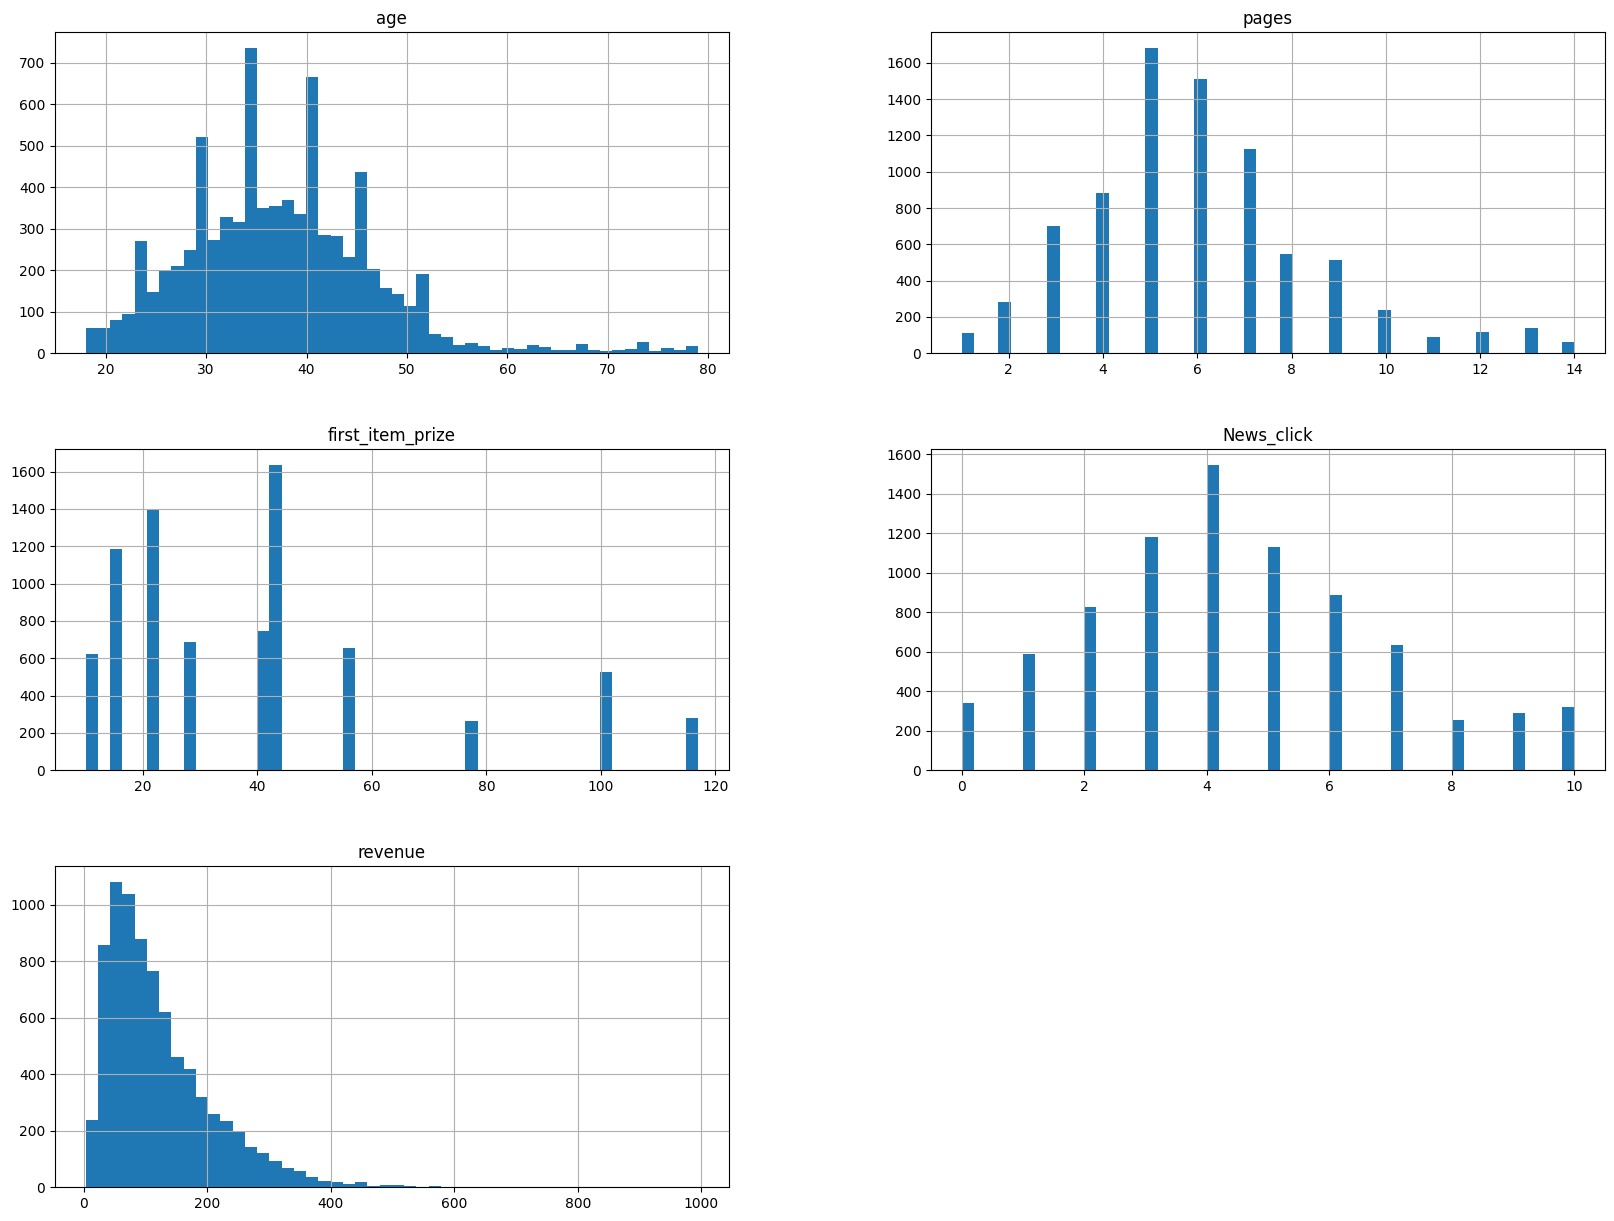

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
data_num.hist(bins=50, figsize=(20,15))
plt.show()

<Axes: xlabel='gender'>

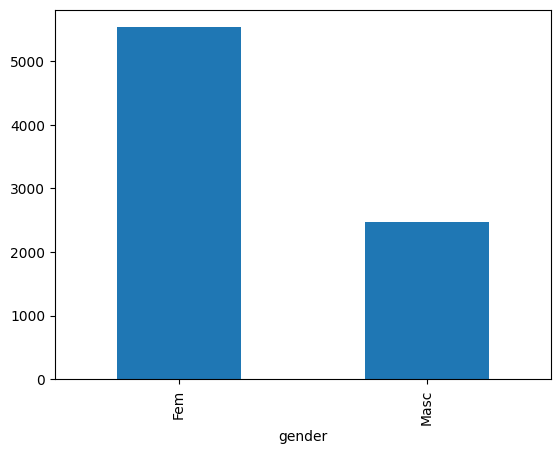

In [10]:
train_set['gender'].value_counts().plot.bar()

In [11]:
corr_matrix =data_num.corr()

In [12]:
corr_matrix['revenue'].sort_values(ascending=False)

revenue             1.000000
News_click          0.374412
first_item_prize    0.367441
age                 0.022159
pages              -0.010377
Name: revenue, dtype: float64

<Axes: >

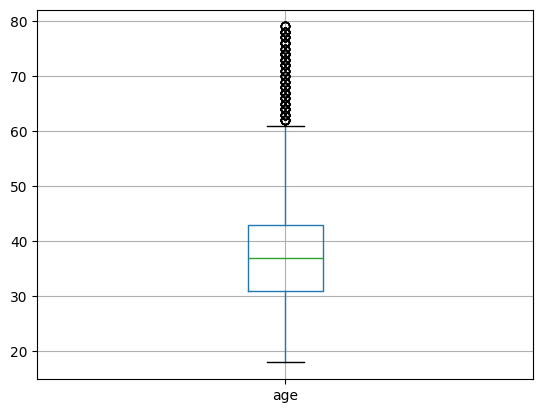

In [13]:
# Recherche des outliers...Exploration visuelle
train_set[['age']].boxplot()
# Il y plusieurs valeurs > Q3

In [14]:
#il faut séparer les entrées/sorties
X_train=train_set.drop(["revenue"], axis=1)
y_train=train_set["revenue"]

In [15]:
#remplcement des vaeurs manquantes
imputer = SimpleImputer(strategy="median")
X=imputer.fit_transform(data_num)

In [16]:
# fonction de nettoyage de données aberrantes qui sera appellee le pipeline
#utilisation de la fonction clip()
def nettoyageOutliers(df: pd.DataFrame) -> pd.DataFrame:
    cols = df.columns
    Q25 = df[cols].quantile(0.25) #Q1 on définit le premier quartile pour c
    Q75 = df[cols].quantile(0.75)
    IQR = Q75 - Q25
    SeuilMin = (Q25 - 1.5 * IQR)
    SeuilMax= (Q75 + 1.5 * IQR)
    nouv_df = df[cols].clip(SeuilMin[cols], SeuilMax[cols], axis=1)
    return nouv_df

<Axes: >

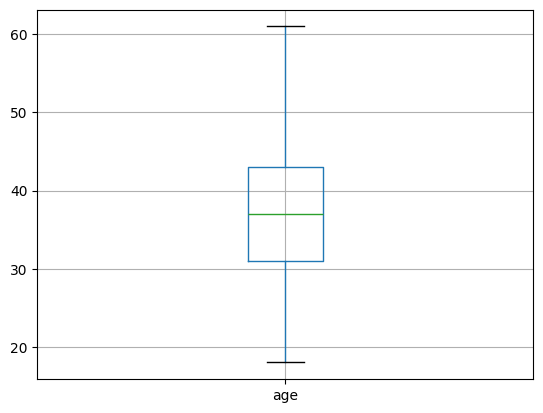

In [17]:
resultat = nettoyageOutliers(pd.DataFrame(X, columns=data_num.columns))
resultat[['age']].boxplot()

In [18]:
def bornage(data):
    return nettoyageOutliers(pd.DataFrame(data))

In [19]:
#il faut remarquer que la variable Country est ecrite en premiere lettre Capital
#C qui n'est pas la meme que celle du dataset Data écrite en minscule "country"
#important pour faire le merge
# d'ou le renommage des colonnes
data_pays = pd.read_csv("CountryPopulation.csv", na_values=['?', 'unknown'])
data_pib = pd.read_csv("CountryGDP.csv", na_values=['?', 'unknown'])
data_pays.columns=['country','population']
data_pib.columns =['country', 'GDP_inhab']

In [20]:
#definition de la fonction merge
#renommage de la colonne country

def mergeDataset(data: pd.DataFrame, pib=False):
    data_enrichie = pd.merge(data, data_pays)
    if pib==True:
        #jointure entre le data et le data_pib
        data_enrichie = data_enrichie.merge(data_pib)
    return data_enrichie

In [21]:
def toNum(data :pd.DataFrame):
    data['first_item_prize']=pd.to_numeric(data['first_item_prize'])
    return data

In [22]:
# Traitement du bruit pour les variables numériques

num_transformer = Pipeline([
    ('toNum', FunctionTransformer(toNum, validate=False)),
    # Nettoyage par remplcement de valeurs manquantes
    ('imputer', SimpleImputer(strategy="median")),
    # Remplacement des données aberrantes
    ('clamp', FunctionTransformer(bornage, validate=False))
])

In [23]:
# Transformation des variables catégorielles
cat_transformer = Pipeline([
     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [24]:
# Prépare toutes les données
preparationData = ColumnTransformer(
    transformers=[
        ('num', num_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', cat_transformer, make_column_selector(dtype_exclude=np.number))
    ]
)

In [25]:
# On met le tout ensemble
full_pipeline = Pipeline([
    ('merge', FunctionTransformer(mergeDataset,kw_args={"pib":True}, validate=False)),
    ('preparation', preparationData)
])

In [26]:
# Mise en oeuvre du pipeline avec les données d'entrainement pour préparer une TBA pour l'entrainement...
leData = full_pipeline.fit_transform(X_train)
pd.DataFrame(leData).head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,36.0,6.0,10.0,3.0,24658823.0,3316.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38.0,3.0,44.0,10.0,24658823.0,3316.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39.0,7.0,22.0,1.0,24658823.0,3316.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44.0,7.0,44.0,1.0,24658823.0,3316.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44.0,7.0,22.0,1.0,24658823.0,3316.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Idem le jeu de test doit être mis dans un format approprié en appliquant directement le pipeline de préparation des données
X_test=test_set.drop(["revenue"], axis=1)
y_test=test_set["revenue"]
TestData = full_pipeline.fit_transform(X_test)
pd.DataFrame(TestData).head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,54.0,3.0,15.5,3.0,38700000.0,7268.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.0,2.0,10.0,4.0,38700000.0,7268.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30.0,1.0,44.0,4.0,38700000.0,7268.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,36.0,6.0,44.0,3.0,38700000.0,7268.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32.0,3.0,28.0,3.0,38700000.0,7268.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
